In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import scipy.io          as scio
import sounddevice       as sd
import os
from   scipy             import signal
from   scipy.interpolate import interp1d
from scipy.io.wavfile    import write

In [3]:
""""Función para estimación de FFT en dB"""

def fou(senal,sr):
    
    f = np.fft.fft(senal)
    h = 20*np.log10(np.abs(f))[:int(f.shape[0]/2)]
    w = np.linspace(0,sr/2,int(f.shape[0]/2))
    
    return h, w

In [4]:
"""Archivos wav"""

def audio(fname,senal,sr):
    L = senal.shape[0]
    t = np.linspace(0,len(senal)/sr,len(senal))
    Lw = 8000
    tw = np.linspace( 0, L/sr, int(L/sr*Lw) )
 
    inter = interp1d(t, senal, kind='cubic')
    Xfwav = inter(tw)
 
    #avoid saturation
    tol   = 1
    xmax  = Xfwav.max()
    xmin  = Xfwav.min()
    Xfwav = 2*tol*(Xfwav/(xmax-xmin) )
 
    ## To integer
#     plt.plot(tw, Xfwav, 'r')
#     plt.grid(True)
#     plt.show()
 
    # Save
    write( fname, Lw, Xfwav )
    
    return Xfwav

In [5]:
datapath = 'C:\\Users\\HP desktop\\Documents\\Trimestre 19I\\Servicio social\\data\\'

In [8]:
""""Cargar datos de señales originales"""

#Onda de presión arterial muestreada a 100 Hz
BPW = scio.loadmat(datapath+'sshs01m.mat')
print('BPW: ',BPW.keys())
BPW      = BPW['val'][0]
sr_BPW   = 100
time_BPW = np.linspace(0,len(BPW)/sr_BPW,len(BPW))

#Fonocardiograma fetal simulado con frecuencia de muestreo de 1 kHz
PCG = scio.loadmat(datapath+'fetalPCG_simulatedSNR-4_4dBm.mat')
print('PCG: ',PCG.keys())
PCG      = PCG['val'][0]
sr_PCG   = 1000
time_PCG = np.linspace(0,len(PCG)/sr_PCG,len(PCG))

#ECG con frecuencia de mustreo 1 kHz 
ECG = scio.loadmat(datapath+'004bm.mat')
print('ECG: ',ECG.keys())
ECG      = ECG['val'][0]
sr_ECG   = 1000
time_ECG = np.linspace(0,len(ECG)/sr_ECG,len(ECG))


#Señal de sonidos respiratorios 
Resp = scio.loadmat(datapath+'bidmc01m.mat')
print('Resp: ',Resp.keys())
Resp      = Resp['val'][0]
sr_Resp   = 125
time_Resp = np.linspace(0,len(Resp)/sr_Resp,len(Resp))

#Señal de sonidos de Korotkoff
f1         = open(datapath+'sonidos.txt','r')
sonidos    = f1.read()
sr_sonidos = 1000
sonidos = sonidos.split(',') #split divide una cadena en una lista 
sonidos = np.asarray(sonidos,dtype=np.float32) #asarray convierte una lista en un vector 


BPW:  dict_keys(['__header__', '__version__', '__globals__', 'val'])
PCG:  dict_keys(['__header__', '__version__', '__globals__', 'val'])
ECG:  dict_keys(['__header__', '__version__', '__globals__', 'val'])
Resp:  dict_keys(['__header__', '__version__', '__globals__', 'val'])


In [10]:
"""Acondicionamiento de señales"""

#BPW
"""Dado a que la señal BPW fue muestreada a una frecuencia de 100 Hz y todas las demás a una frecuencia de 1 kHz
   se optó por realizar una interpolación cúbica de dicha señal para poder generar una BPW muestreada a 1 kHz"""

f = interp1d(time_BPW, BPW, kind='cubic')
time_n = np.linspace(time_BPW[0], time_BPW[-1], num=len(BPW)*10, endpoint=True)
mmHg_n = f(time_n)

"""Con este fragmento de código se verifica que la nueva sr de la señal BPW sea de 1 kHz"""
dT = time_n[2]-time_n[1]
fm = 1/dT
print(fm)

#Respiración 
f = interp1d(time_Resp, Resp, kind='cubic')
time_r = np.linspace(time_Resp[0], time_Resp[-1], num=len(Resp)*8, endpoint=True)
Resp_r = f(time_r)

dT = time_r[2]-time_r[1]
fm = 1/dT
print(fm)

"""Con esto podemos generar una sr general para todas nuestras señales, así como un eje de tiempo general"""
sr   = 1000.
time = time_n

"""Para el caso de la señal de sonidos de Korotkoff se necesita generar un eje de tiempo diferente debido a que tiene una
duración de solo 30 seg"""
t_sonidos = np.linspace(0,len(sonidos)/sr_sonidos,len(sonidos))

999.9833333333332
999.9833333333332


Text(0,0.5,'Sonidos de Korotkoff')

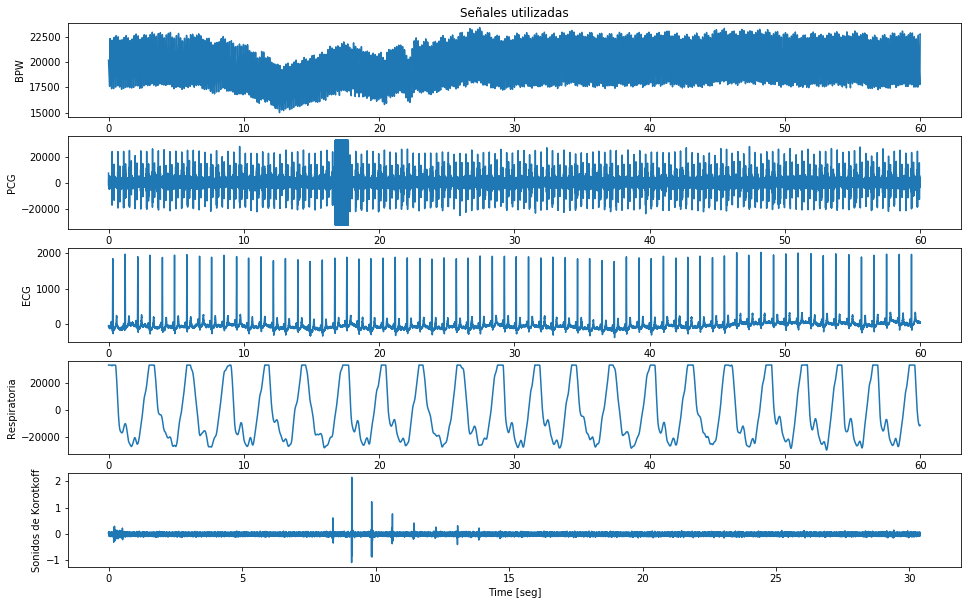

In [18]:
plt.figure(figsize=(16,10))
plt.subplot(5,1,1)
plt.plot(time,mmHg_n)
plt.title('Señales utilizadas')
plt.ylabel('BPW')
plt.subplot(5,1,2)
plt.plot(time,PCG)
plt.ylabel('PCG')
plt.subplot(5,1,3)
plt.plot(time,ECG)
plt.ylabel('ECG')
plt.subplot(5,1,4)
plt.plot(time,Resp_r)
plt.ylabel('Respiratoria')
plt.subplot(5,1,5)
plt.plot(t_sonidos,sonidos)
plt.xlabel('Time [seg]')
plt.ylabel('Sonidos de Korotkoff')

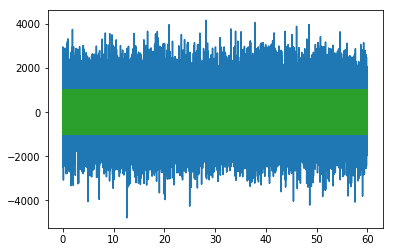

In [19]:
"""Señales para contaminar"""

#Amplitud de las señales de ruido
A = 1000

#10k muestras de ruido gaussiano con desviación estándar de 10 y centradas en 0
x = np.random.normal(0,A,len(time))

#Senoidal de 60 Hz
sen_60 = np.sin(time*2*np.pi*60)*100

#Senoidal de 50 Hz
sen_50 = np.sin(time*2*np.pi*50)*A


plt.figure()
plt.plot(time,x)
plt.plot(time,sen_60)
plt.plot(time,sen_50)
# plt.axis([0,0.1,-6,6])

In [20]:
"""Se utilizo ruido gaussiano entre una frecuencia de 80 y 90 Hz, fue filtrado con filtro butterworth orden 2"""

n       = 2
fc_g    = 2*np.array( [100, 110] )/sr
bg,ag   = signal.butter(n, fc_g, btype='band', output='ba')

x_g = signal.filtfilt(bg,ag,x)
# plt.figure()
# plt.plot(time,CZ_0B)
# plt.xlim(2,2.25)

h,w = fou(x_g,sr)
# plt.figure()
# plt.plot(w,h)

C:\Users\HP desktop\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


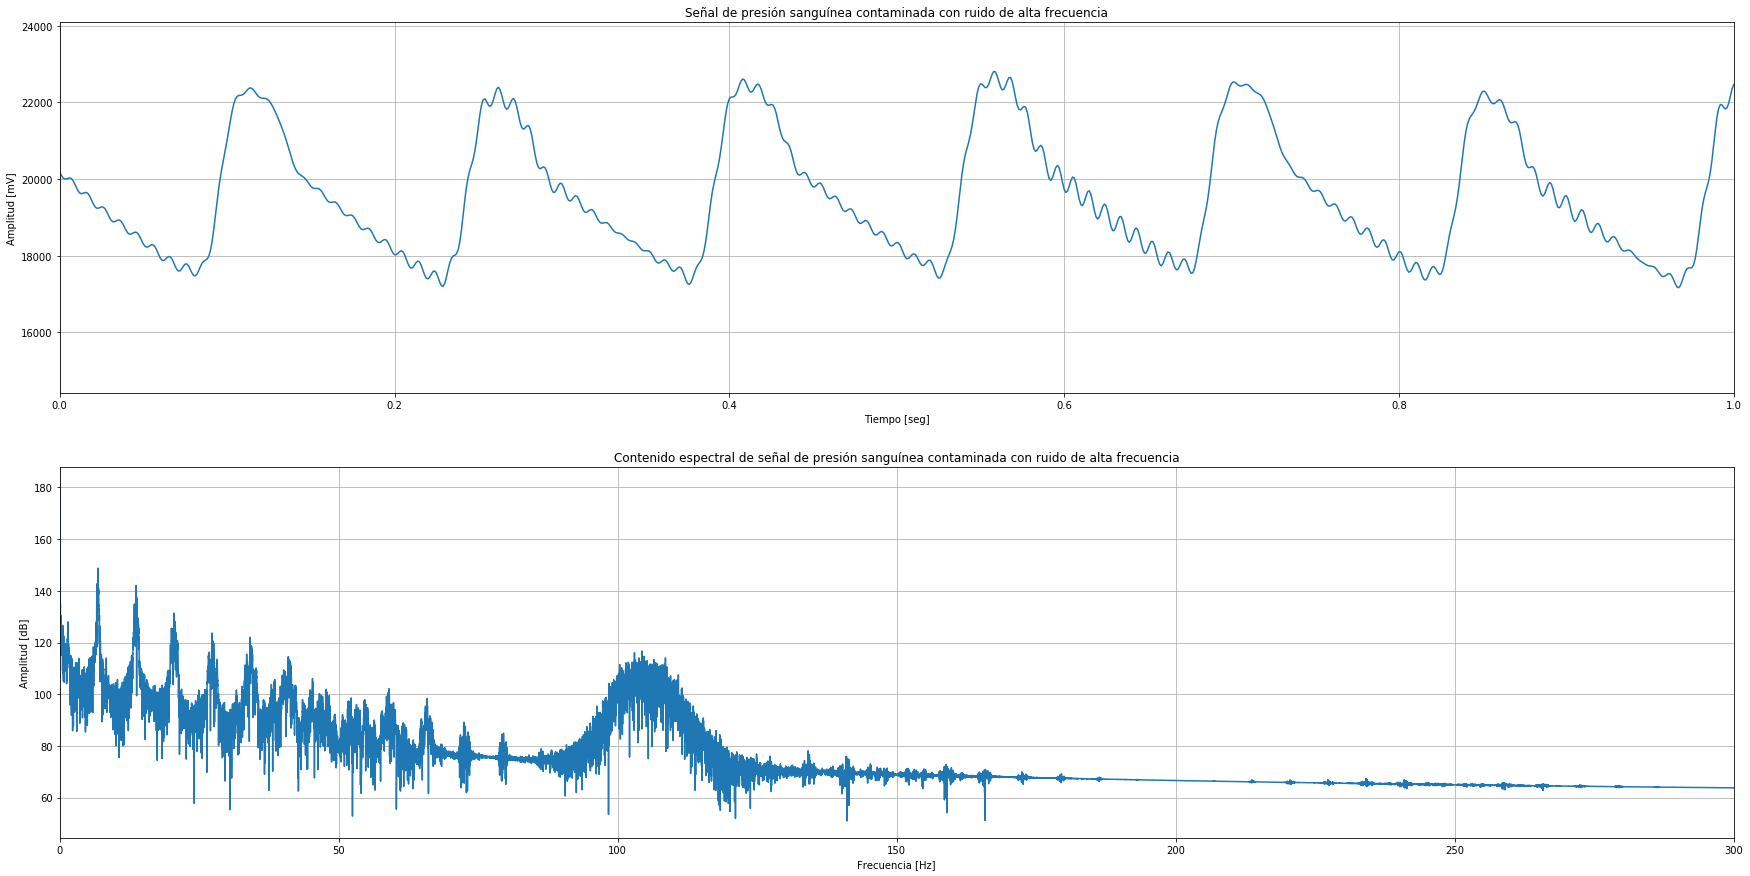

In [21]:
"""Contaminación de señal de presión sanguínea"""

BPW_c = mmHg_n + x_g
plt.figure(figsize = (30,15))
plt.subplot(2,1,1)
plt.plot(time,BPW_c)
plt.title('Señal de presión sanguínea contaminada con ruido de alta frecuencia')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [mV]')
plt.xlim(0,1)
plt.grid(True)

h,w = fou(BPW_c,sr)
plt.subplot(2,1,2)
plt.plot(w,h)
plt.title('Contenido espectral de señal de presión sanguínea contaminada con ruido de alta frecuencia')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.xlim(0,300)
plt.grid(True)

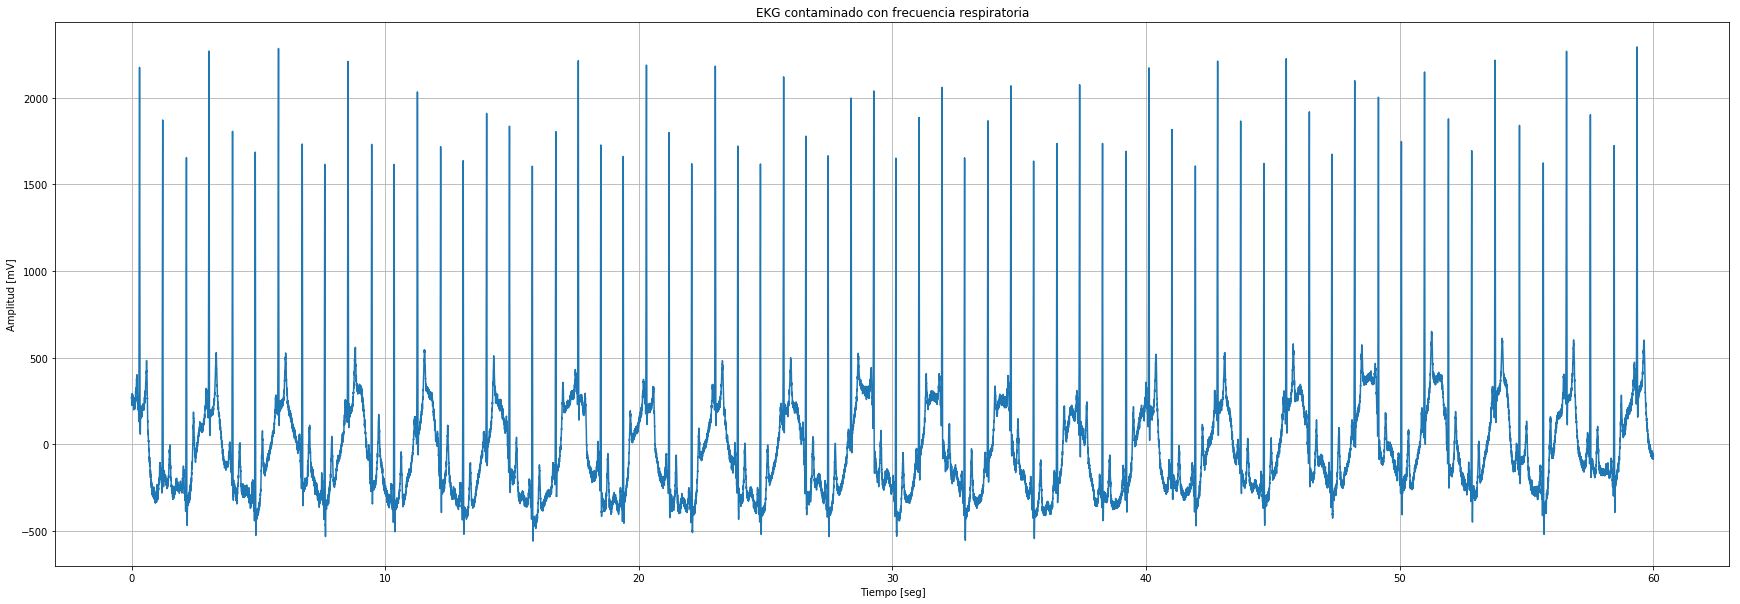

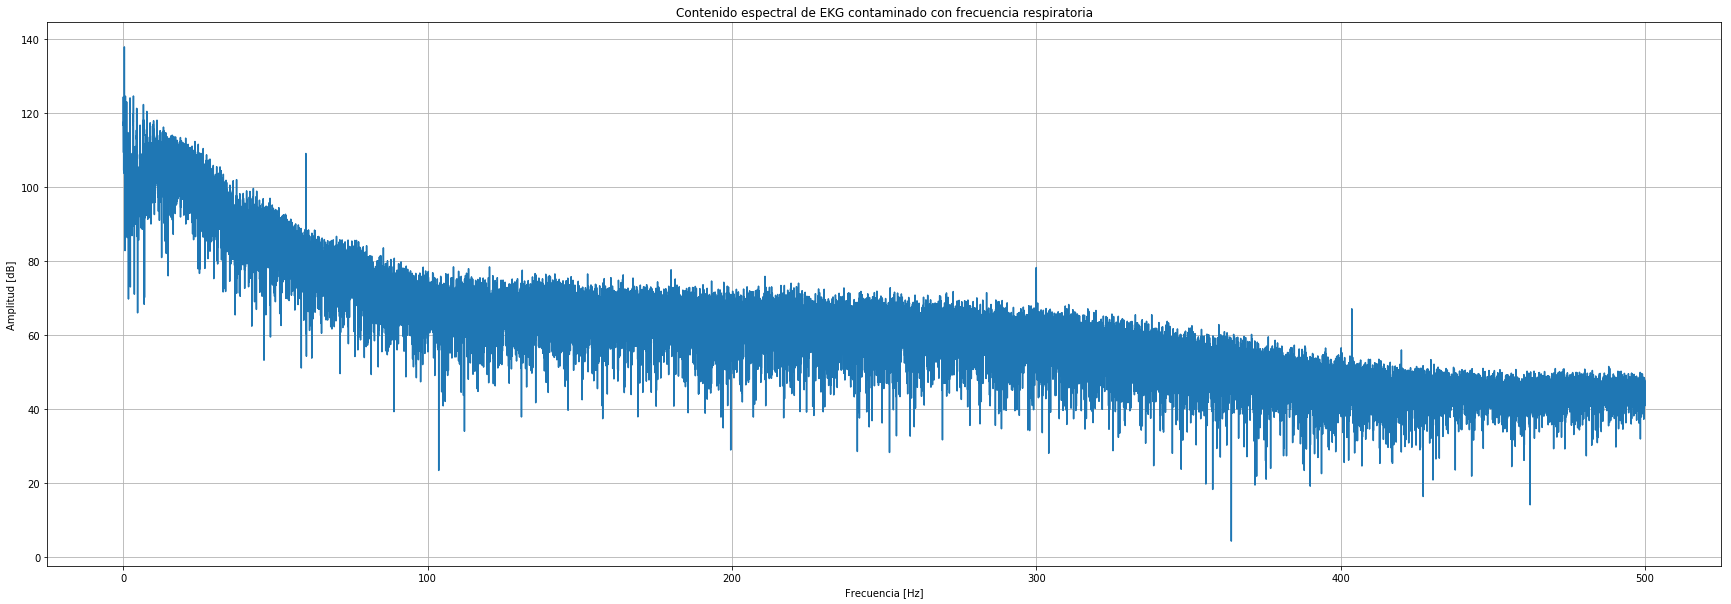

In [24]:
"""Contaminación de señal de EKG con ruido de frecuencia respiratoria"""

ECG_r = Resp_r/100 + ECG

plt.figure(figsize = (30,10))
plt.plot(time, ECG_r)
plt.title('EKG contaminado con frecuencia respiratoria')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

h, w = fou(ECG_r, sr)
plt.figure(figsize = (30,10))
plt.plot(w,h)
plt.title('Contenido espectral de EKG contaminado con frecuencia respiratoria')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)

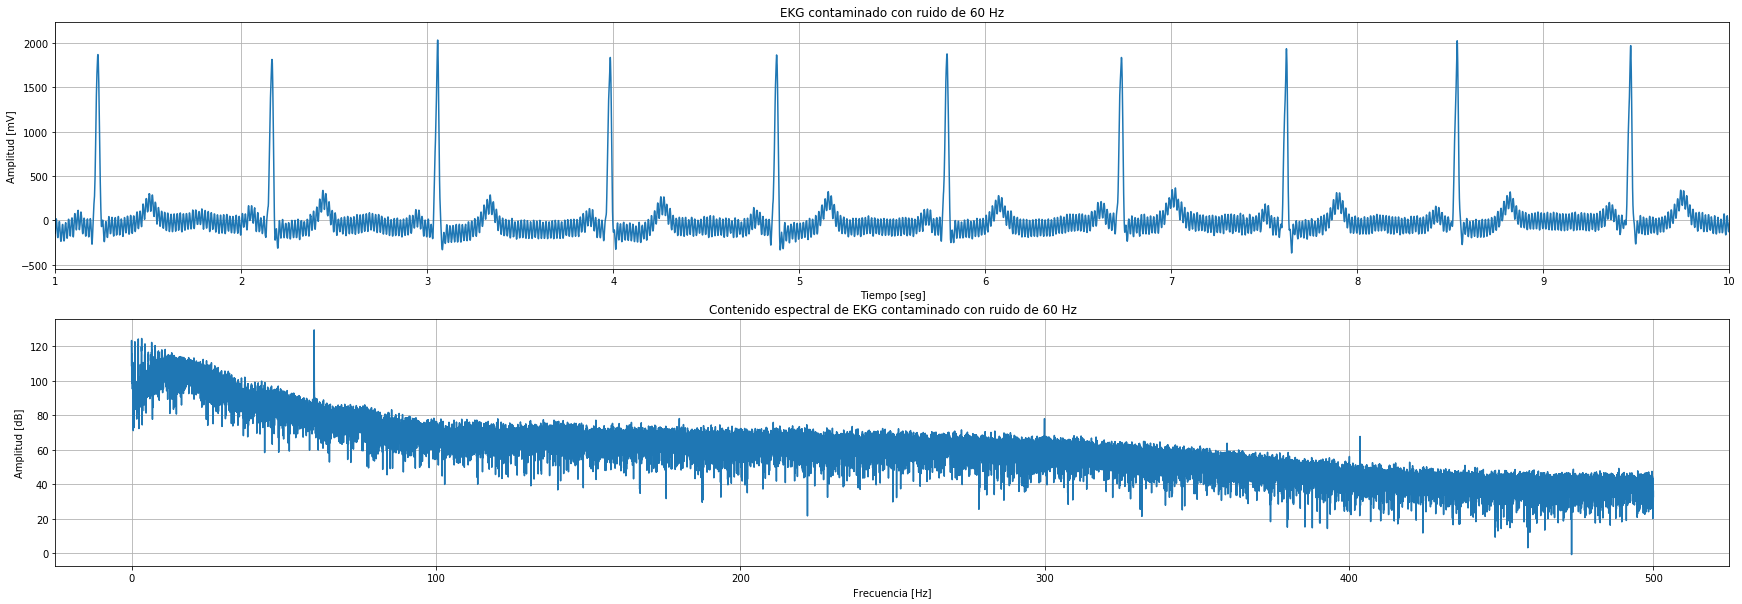

In [25]:
"""Contaminación de EKG con ruido de 60 Hz"""

ECG_60 = sen_60 + ECG

plt.figure(figsize = (30,10))
plt.subplot(2,1,1)
plt.plot(time, ECG_60)
plt.xlim(1,10)
plt.title('EKG contaminado con ruido de 60 Hz')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

h, w = fou(ECG_60, sr)
plt.subplot(2,1,2)
plt.plot(w,h)
plt.title('Contenido espectral de EKG contaminado con ruido de 60 Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)

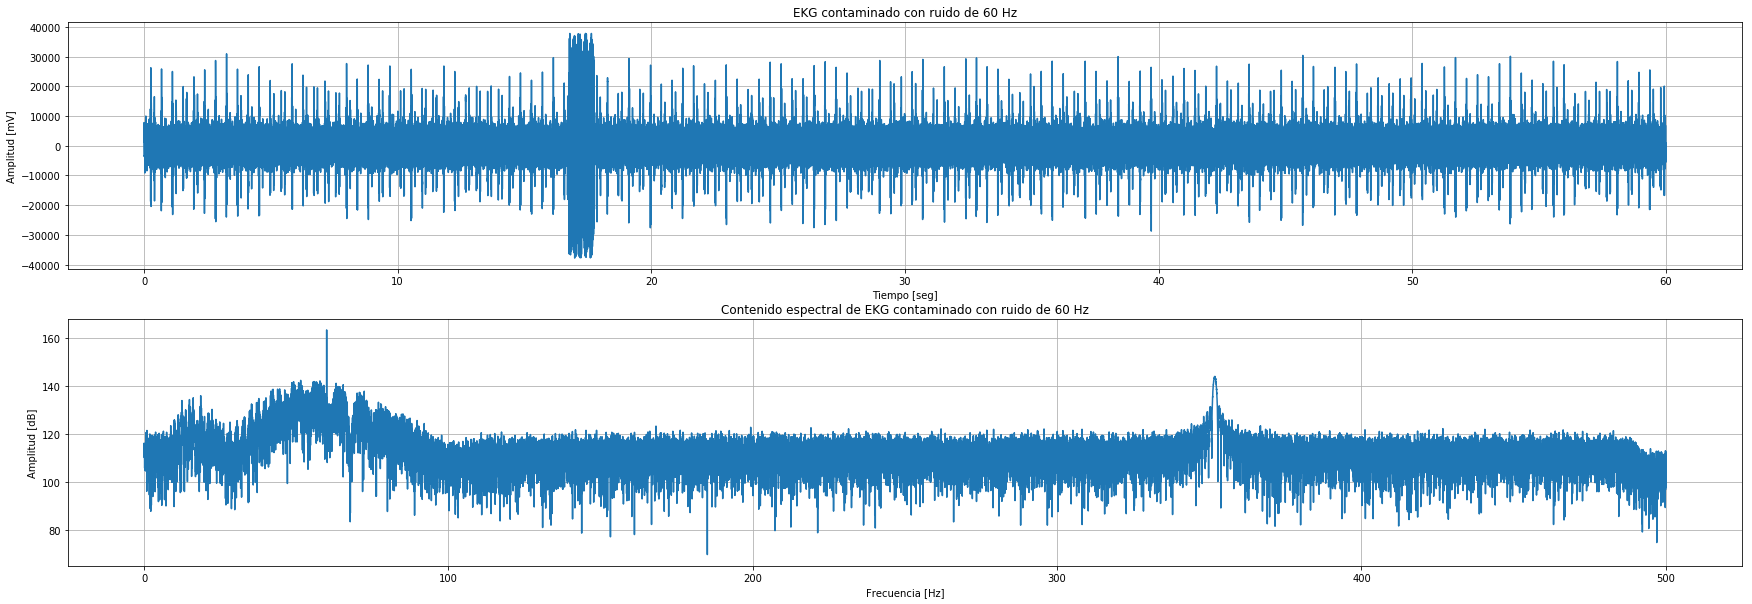

In [26]:
"""Contaminación de PCG con ruido de 60 Hz"""

sen_r = np.sin(time*2*np.pi*60)*5000

PCG_60 = sen_r + PCG

plt.figure(figsize = (30,10))
plt.subplot(2,1,1)
plt.plot(time, PCG_60)
plt.title('EKG contaminado con ruido de 60 Hz')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

h, w = fou(PCG_60, sr)
plt.subplot(2,1,2)
plt.plot(w,h)
plt.title('Contenido espectral de EKG contaminado con ruido de 60 Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)

In [27]:
"""Guardado de señales limpias y contaminadas en formato nativo de numpy"""

np.savez_compressed(datapath+'BPW',BPW=mmHg_n,sr=sr)
np.savez_compressed(datapath+'PCG',PCG=PCG,sr=sr)
np.savez_compressed(datapath+'ECG',ECG=ECG,sr=sr)
np.savez_compressed(datapath+'Resp',Resp=Resp_r,sr=sr)

"""Señales contaminadas en archivo npz"""
np.savez_compressed(datapath+'ECG_r',ECG_r=ECG_r,sr=sr)
np.savez_compressed(datapath+'ECG_60',ECG_60=ECG_60,sr=sr)
np.savez_compressed(datapath+'BPW_c',BPW_c=BPW_c,sr=sr)
np.savez_compressed(datapath+'PCG_60',PCG=PCG_60,sr=sr)
np.savez_compressed(datapath+'sonidos',sonidos=sonidos,sr=sr)

In [16]:
"""Acordes"""

Fm = 8000
time = np.linspace(0,10,Fm*10)

frec = [261.63,277.18,293.66,311.13,329.63,349.23,369.99,392.,415.3,440.0,466.0,493.88,523.25,554.37,587.33,622.25,659.26,698.46,739.99]
notes = []

for i in range(len(frec)):
    tem = np.sin(2*np.pi*time*frec[i])
    notes.append(tem.tolist()) 
    
notes = np.asarray(notes, np.float)

In [17]:
chords = []

for i in [0,2,4,5,7,9,11]:
    tem = notes[i]+notes[i+4]+notes[i+7]
    chords.append(tem.tolist())

In [18]:
chords = np.asarray(chords, np.float)
# sd.play(chords[0,:],Fm)

(200, 500)

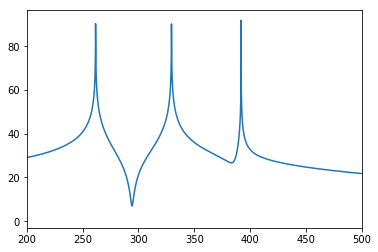

In [19]:
h,w = fou(chords[0,:],Fm)
plt.plot(w,h)
plt.xlim(200,500)

In [20]:
"""Guardar archivos como wav"""

y = audio(datapath+'BPW.wav',mmHg_n,sr)
y = audio(datapath+'BPW_noise.wav',BPW_c,sr)
y = audio(datapath+'PCG.wav',PCG,sr)
y = audio(datapath+'PCG_noise.wav',PCG_60,sr)
y = audio(datapath+'ECG.wav',ECG,sr)
y = audio(datapath+'ECG_resp.wav',ECG_r,sr)
y = audio(datapath+'ECG_60.wav',ECG_60,sr)
y = audio(datapath+'Resp.wav',Resp_r,sr)